In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

In [2]:
EPOCHS = 200
BATCH_SIZE = 32

In [ ]:
data = np.load("../data/processed_data.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
dir_test = data["dir_test"]
window_size = int(data["window_size"])
n_features = data["n_features"]

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((288, 30, 3), (288,), (80, 30, 3), (80,))

In [5]:
y_train.min(), y_train.max(), y_train.mean(), y_train.std()

(0.0, 1.0, 0.5576672192140384, 0.2333724671495153)

In [6]:
X_train = X_train.reshape((X_train.shape[0], window_size, n_features))
X_test = X_test.reshape((X_test.shape[0], window_size, n_features))

In [7]:
model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(window_size, n_features)))
model.add(Dropout(0.3))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=5e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 128)          34816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 gru (GRU)                   (None, 30, 64)            37248     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                        

In [8]:
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('../models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=[es, rlrp, checkpoint],
    verbose=1
)

Epoch 1/200
7/8 [=========================>....] - ETA: 0s - loss: 0.1187
Epoch 1: val_loss improved from inf to 0.02548, saving model to ../models\best_model.keras
8/8 [==============================] - 9s 160ms/step - loss: 0.1105 - val_loss: 0.0255 - lr: 5.0000e-04
Epoch 2/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0474
Epoch 2: val_loss did not improve from 0.02548
8/8 [==============================] - 0s 26ms/step - loss: 0.0456 - val_loss: 0.0666 - lr: 5.0000e-04
Epoch 3/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0270
Epoch 3: val_loss did not improve from 0.02548
8/8 [==============================] - 0s 24ms/step - loss: 0.0260 - val_loss: 0.1160 - lr: 5.0000e-04
Epoch 4/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0209
Epoch 4: val_loss did not improve from 0.02548
8/8 [==============================] - 0s 26ms/step - loss: 0.0209 - val_loss: 0.0305 - lr: 5.0000e-04
Epoch 5/200
7/8 [=========================>....] - ETA: 0s 

In [10]:
train_loss = history.history['loss'][-1]
val_loss = history.history.get('val_loss', [None])[-1]
print(f"Final losses -> train: {train_loss:.6f}, val: {val_loss:.6f}")

Final losses -> train: 0.003849, val: 0.009488


In [ ]:
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')

In [12]:
pred_scaled = model.predict(X_test).flatten()
predicted = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

3/3 [==============================] - 1s 9ms/step


In [13]:
prev_scaled = X_test.reshape(X_test.shape[0], window_size, n_features)[:, -1, 0].reshape(-1, 1)
prev_actuals = scaler_X.inverse_transform(np.hstack([prev_scaled, np.zeros((prev_scaled.shape[0], n_features-1))]))[:, 0]

In [14]:
predictions_on_true_test = predicted[window_size:]
actuals_on_true_test = y_test[window_size:]
prev_actuals_true_test = prev_actuals[window_size:]

In [15]:
pred_dir_binary = (predictions_on_true_test > prev_actuals_true_test).astype(int)
actual_dir_binary = (actuals_on_true_test > prev_actuals_true_test).astype(int)

In [16]:
direction_accuracy = (pred_dir_binary == actual_dir_binary).mean() * 100
print(f"Direction accuracy (predicted > previous actual): {direction_accuracy:.2f}%")

Direction accuracy (predicted > previous actual): 44.00%


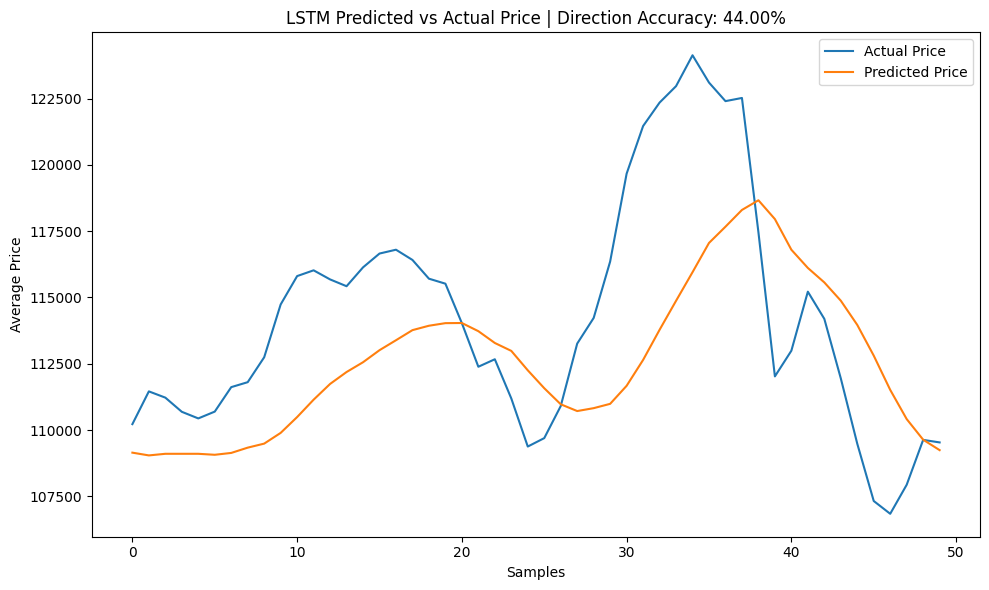

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_on_true_test, label="Actual Price")
plt.plot(predictions_on_true_test, label="Predicted Price")
plt.title(f"LSTM Predicted vs Actual Price | Direction Accuracy: {direction_accuracy:.2f}%")
plt.xlabel("Samples")
plt.ylabel("Average Price")
plt.legend()
plt.tight_layout()
plt.show()